In [312]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RepeatedKFold
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [313]:
df= pd.read_csv('dataset_coherencia.csv')

# XGBOOST MINIMENTAL COMO TARGET

In [314]:
for col in df.columns:
    print(f'{col}')

area_vivienda
sexo
edad
num_personas_hogar
grupo_etnico
raza
a_educacion
edad_primer_trabajo
dependencia_economica
habitacion_unica
utiliza_computador
utiliza_internet
sentirse_viejo
escribe
resuelve_matematica
pasatiempos
escuchar_radio
ver_television
juegos_de_mesa
manualidades
hablar_con_familiares
visitar_familiares
actividad_fisica
asistir_cursos
hobbies
compras
bibliotecas_museos
eventos_cult_dep
viajar
participa_grupos
beneficiario_alimentacion
beneficiario_col_mayor
desplazado
comidas_al_dia
lacteos
granos
carne
frutas_verduras
cons_vino
cons_cerveza
cons_licor
ejercicio
caminar
economia_familiar
salud_adolescencia
hambre_adolescencia
violencia_adolescencia
vision
problemas_auditivos
rechazo_infancia
abuso_gritos
abuso_maltrato_fisico
abuso_agresion
abandono
abuso_economico
hipertension
diabetes
cancer
asma
enfermedad_cardiaca
derrame_cerebral
artrosis
osteoporosis
enfermedad_mental
hospitalizacion
peso
talla
circunferencia_cintura
IMC
velocidad_marcha
orientacion
conteo
minime

In [315]:
#variable dependiente
y = df['minimental']
#variables independientes
x = df.drop(['minimental','coherencia_unica','normal','orientacion', 'conteo','borderline','minimental_norm','coherencia'], axis = 1)#normal,orientacion

In [316]:
def XGB(x,y):
    # separar en train y test sets
    X_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state = 20)
    # crear objeto regressor
    model = xgb.XGBRegressor()
    # entrenar modelo
    model.fit(x,y)
    # testear modelo
    predicted = model.predict(x_test)
    
    return predicted, x_test, y_test, model
    

In [317]:
predicted, x_test, y_test, model = XGB(x,y)

## Evaluación del modelo (minimental como target)

In [318]:
#Root mean squared error
rmse = np.sqrt(MSE(y_test, predicted))
print("RMSE : % f" %(rmse))

RMSE :  0.396481


In [319]:
# Evaluar el modelo usando K-fold
def k_fold(x,y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

In [320]:
scores = abs(k_fold(x,y))
print(f'Mean MAE: {scores.mean()}, {scores.std()}' )

Mean MAE: 1.671413185373439, 0.07516305881499842


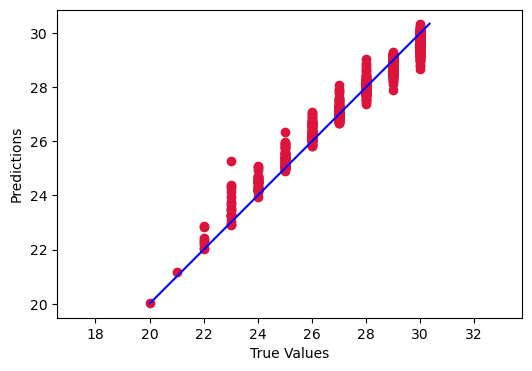

In [321]:
# Plot que muestra la diferencia entre predicted vs real values.
plt.figure(figsize=(6,4))
plt.scatter(y_test, predicted, c='crimson')
p1 = max(max(predicted), max(y_test))
p2 = min(min(predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=10)
plt.ylabel('Predictions', fontsize=10)
plt.axis('equal')
plt.show()

In [322]:
perm_importance = permutation_importance(model, x_test, y_test, n_repeats = 7)

In [323]:
len(df.columns)

213

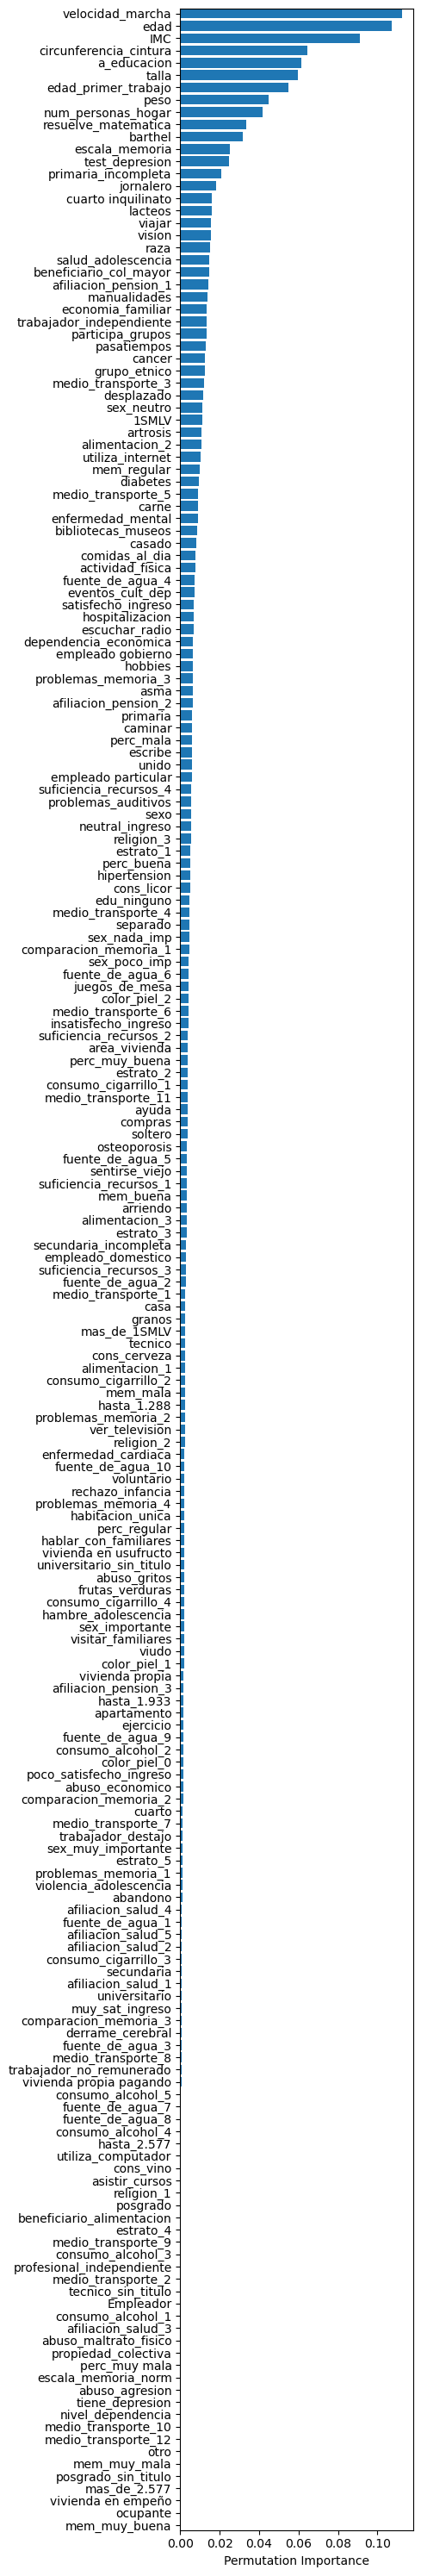

In [324]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(5,30))
plt.barh(model.feature_names_in_[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.margins(y=0) 
plt.tight_layout()

# XGBOOST ESCALA MEMORIA COMO TARGET

In [325]:
#variable dependiente
y = df['escala_memoria']
#variables independientes
x = df.drop(['escala_memoria','escala_memoria_norm','coherencia_unica','coherencia','problemas_memoria_4','problemas_memoria_3','problemas_memoria_2','problemas_memoria_1','minimental_norm','comparacion_memoria_1','comparacion_memoria_2','comparacion_memoria_3','mem_mala','mem_regular','mem_buena','mem_muy_mala'], axis = 1)

In [326]:
predicted, x_test, y_test, model = XGB(x,y)

In [327]:
#Root mean squared error
rmse = np.sqrt(MSE(y_test, predicted))
print("RMSE : % f" %(rmse))

RMSE :  0.330501


In [328]:
#MAE
scores = abs(k_fold(x,y))
print(f'Mean MAE: {scores.mean()}, {scores.std()}' )

Mean MAE: 1.3462616734366486, 0.06265965344574212


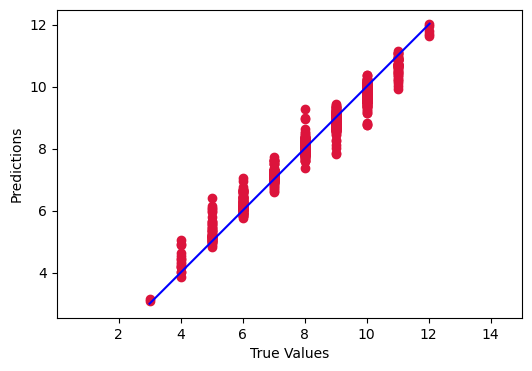

In [329]:
# Plot que muestra la diferencia entre predicted vs real values.
plt.figure(figsize=(6,4))
plt.scatter(y_test, predicted, c='crimson')
p1 = max(max(predicted), max(y_test))
p2 = min(min(predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=10)
plt.ylabel('Predictions', fontsize=10)
plt.axis('equal')
plt.show()

In [330]:
perm_importance = permutation_importance(model, x_test, y_test, n_repeats = 50)

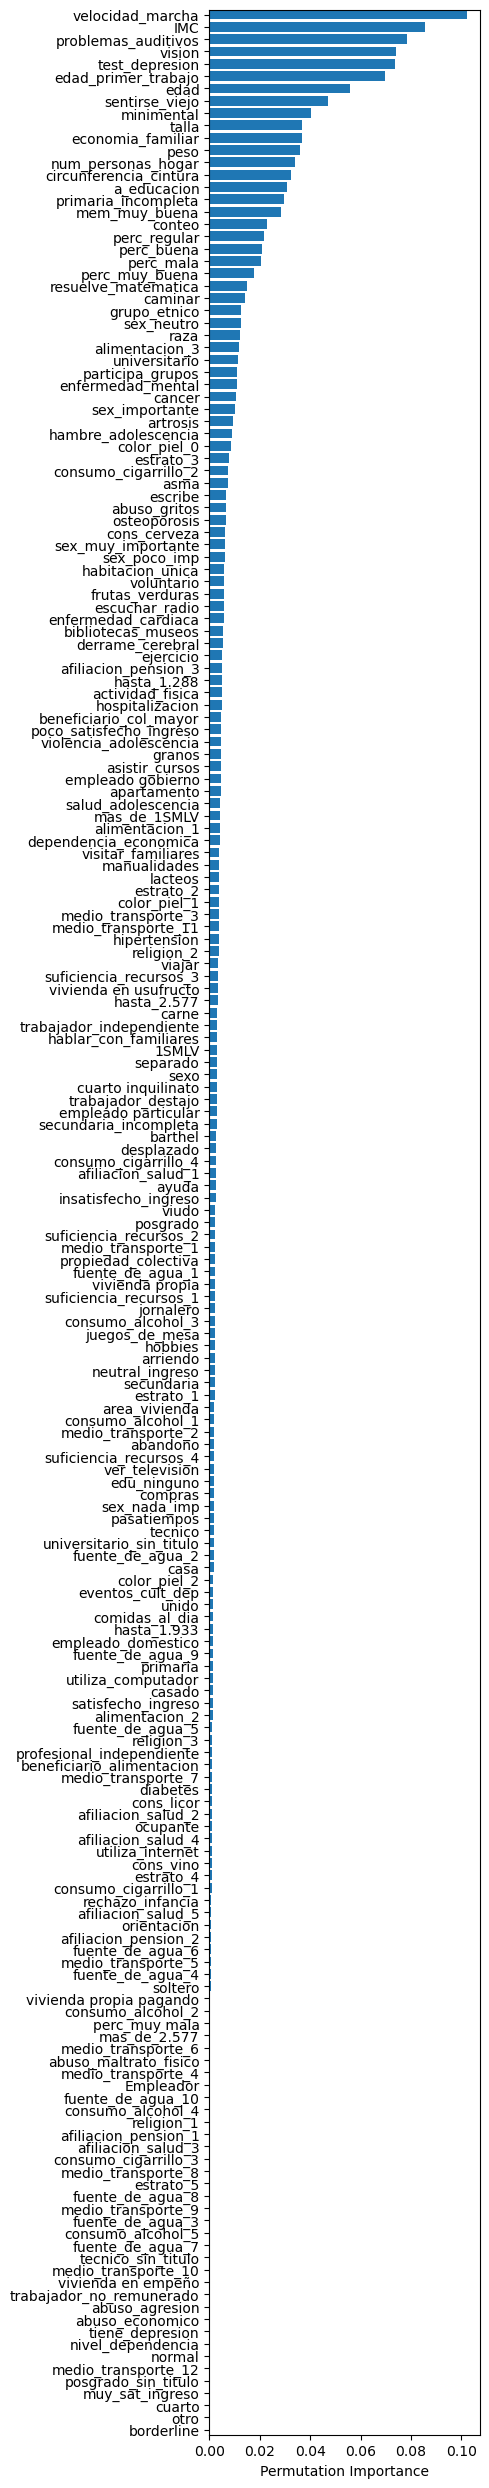

In [331]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(5,25))
plt.barh(model.feature_names_in_[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.margins(y=0)
plt.tight_layout()

## *Valor P para permutation importances*

- H0: Las distribuciones baseline del performance y performance del modelo cuando las variables son alteradas no difieren
- Ha: La distribución baseline del performance(cuando las variables no son alteradas) es mayor que la distribución del performance del modelo cuando las variables son alteradas.
      


In [332]:
#Determinar scorer para obtener el baseline performance del modelo
from sklearn.metrics import check_scoring
scorer = check_scoring(model, None)

In [333]:
def _weights_scorer(scorer, estimator, X, y, sample_weight):
    if sample_weight is not None:
        return scorer(estimator, X, y, sample_weight)
    return scorer(estimator, X, y)

# baseline score performance del modelo
baseline_score = _weights_scorer(scorer, model, x, y, None)

In [334]:
baseline_score

0.9676799728818853

In [335]:
perm_importance['importances'].shape

(197, 50)

In [336]:
baseline_score = np.random.normal(baseline_score, 0.2, (1,50))

In [337]:
baseline_score

array([[1.05732773, 0.92826971, 0.95974345, 1.02494876, 0.79443355,
        0.85216077, 1.11831524, 1.27975997, 0.65658836, 1.11355728,
        1.72748402, 0.98322623, 0.82853527, 1.3152139 , 0.96099072,
        1.52998314, 0.68993286, 1.26317634, 1.04479026, 0.68157079,
        0.89637766, 1.05191845, 0.88301546, 1.153435  , 0.80535611,
        1.01587421, 0.88446253, 0.86054003, 1.01286319, 1.0733905 ,
        1.14124556, 0.98224458, 0.97311597, 0.55424114, 0.92936683,
        1.10033261, 0.99708455, 0.61092919, 1.20238217, 0.88670754,
        0.84399382, 1.20350874, 0.82594685, 0.91900288, 1.02898347,
        0.8606334 , 1.48017757, 0.86935365, 0.96827898, 0.8260372 ]])

In [338]:
perm_importance['importances'][1]

array([0.00257091, 0.00270333, 0.00367541, 0.00308843, 0.00228342,
       0.00371534, 0.00326471, 0.00311556, 0.00260819, 0.00351545,
       0.00288172, 0.00316007, 0.00289794, 0.00322055, 0.00289591,
       0.00387072, 0.00307012, 0.0028716 , 0.00282636, 0.00288491,
       0.00236774, 0.0027785 , 0.0032079 , 0.00310653, 0.00338791,
       0.00284876, 0.00257693, 0.00300461, 0.00297467, 0.00344591,
       0.00322257, 0.0035476 , 0.00347755, 0.00236185, 0.00319663,
       0.00345665, 0.0027279 , 0.00263947, 0.00317026, 0.00309371,
       0.00268252, 0.00304512, 0.00336277, 0.00236598, 0.00386867,
       0.00314452, 0.00234721, 0.00232614, 0.00375233, 0.0023276 ])

In [339]:
from scipy.stats import mannwhitneyu
def p_values_func(baseline_score, perm_importance, length):
    p_dict = {'p':[],'stat':[] ,'difference':[]}
    
    #baseline_score = np.repeat(baseline_score,50)
    baseline_score = np.random.normal(baseline_score, 0.2, 50)
    for i in range(length):
        score_afterperm = baseline_score - perm_importance['importances'][i]
        difference = baseline_score-score_afterperm
        stat, p = mannwhitneyu(score_afterperm, baseline_score, alternative ='less')
        p_dict['p'].append(p)
        p_dict['stat'].append(stat)
        p_dict['difference'].append(np.mean(difference))
        
    return p_dict

In [343]:
length = len(perm_importance['importances'])


In [344]:
p_values = p_values_func(0.9676799728818853, perm_importance, length)

Los puntos analizados por p_values son muy similares, por lo que hay una diferencia muy pequeña entre los datos.
Esta diferencia es luego amplificada al hacer calculos matematicos, resultando en un error mayor al real y por ende en datos no confiables. 

In [345]:
p = pd.DataFrame(data= p_values)

In [346]:
p

,p,stat,difference
0,0.422120,1221.0,0.002034
1,0.411360,1217.0,0.003019
2,0.073369,1039.0,0.055777
3,0.154615,1102.0,0.033869
4,0.315926,1180.0,0.012703
...,...,...,...
192,0.414044,1218.0,0.002981
193,0.501375,1250.0,0.000000
194,0.501375,1250.0,0.000000
195,0.501375,1250.0,0.000000


In [347]:
p.query('p<= 0.05')

,p,stat,difference
7,0.035177,987.0,0.069612
47,0.027872,972.0,0.074196
48,0.024130,963.0,0.078460
68,0.017302,943.0,0.085377
69,0.007693,898.0,0.102235
73,0.029684,976.0,0.073446


In [348]:
p.query('difference>= 0.05')

,p,stat,difference
2,0.073369,1039.0,0.055777
7,0.035177,987.0,0.069612
47,0.027872,972.0,0.074196
48,0.024130,963.0,0.078460
68,0.017302,943.0,0.085377
69,0.007693,898.0,0.102235
73,0.029684,976.0,0.073446


In [370]:

#Aquellas variables cuya diferencia en performance del modelo es mayor a 0.05
indexes = p[p['difference'] >= 0.05].index.tolist()


In [371]:
for i in indexes:
    print(i, df.columns[i])

2 edad
3 num_personas_hogar
7 edad_primer_trabajo
47 vision
48 problemas_auditivos
65 peso
67 circunferencia_cintura
68 IMC
69 velocidad_marcha
192 neutral_ingreso


# COHERENCIA COMO TARGET XG BOOST

In [351]:
#variable dependiente
y = df['coherencia']
#variables independientes
x = df.drop(['escala_memoria','escala_memoria_norm','coherencia','coherencia_unica','problemas_memoria_4','problemas_memoria_3','problemas_memoria_2','problemas_memoria_1','comparacion_memoria_1','comparacion_memoria_2','comparacion_memoria_3','orientacion','conteo','mem_mala','mem_regular','mem_buena','mem_muy_mala','minimental','minimental_norm'], axis = 1)

In [352]:
predicted, x_test, y_test, model = XGB(x,y)

In [353]:
#Root mean squared error
rmse = np.sqrt(MSE(y_test, predicted))
print("RMSE : % f" %(rmse))

RMSE :  0.050261


In [354]:
scores = abs(k_fold(x,y))
print(f'Mean MAE: {scores.mean()}, {scores.std()}' )

Mean MAE: 0.21283105653328907, 0.009337231346223227


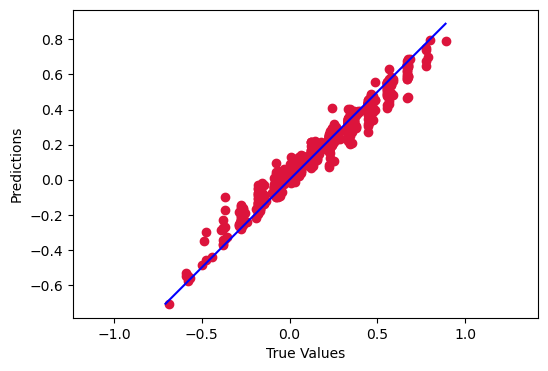

In [355]:
# Plot que muestra la diferencia entre predicted vs real values.
plt.figure(figsize=(6,4))
plt.scatter(y_test, predicted, c='crimson')
p1 = max(max(predicted), max(y_test))
p2 = min(min(predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=10)
plt.ylabel('Predictions', fontsize=10)
plt.axis('equal')
plt.show()

In [356]:
from sklearn.metrics import check_scoring
scorer = check_scoring(model, None)


In [357]:
def _weights_scorer(scorer, estimator, X, y, sample_weight):
    if sample_weight is not None:
        return scorer(estimator, X, y, sample_weight)
    return scorer(estimator, X, y)

baseline_score = _weights_scorer(scorer, model, x, y, None)


In [358]:
baseline_score

0.9608624464210558

In [359]:
perm_importance = permutation_importance(model, x_test, y_test, n_repeats = 50)

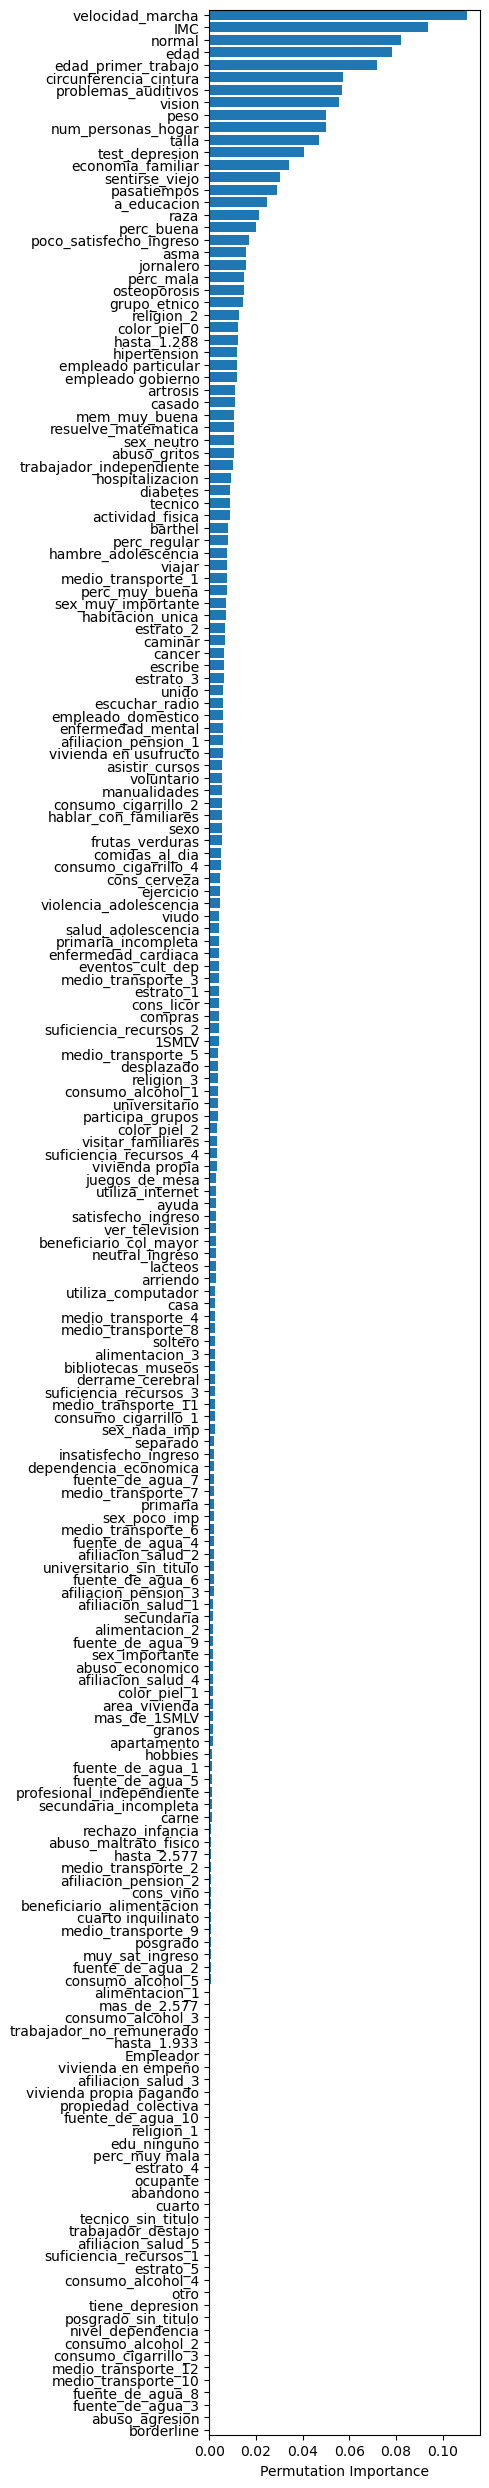

In [360]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(5,25))
plt.barh(model.feature_names_in_[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.margins(y=0)
plt.tight_layout()

In [361]:
baseline_score

0.9608624464210558

In [362]:
length = len(perm_importance['importances'])

In [363]:
length

194

In [364]:
p_values = p_values_func(baseline_score, perm_importance, length)

In [365]:
p = pd.DataFrame(data= p_values)

In [366]:
p.query('difference>= 0.05')

,p,stat,difference
2,0.012198,923.0,0.078224
3,0.065995,1031.0,0.050024
7,0.017901,945.0,0.071848
47,0.047287,1007.0,0.055701
48,0.043984,1002.0,0.057048
65,0.062530,1027.0,0.050060
67,0.047971,1008.0,0.057272
68,0.004099,866.0,0.093755
69,0.001252,811.0,0.110439
192,0.010947,917.0,0.082296


In [367]:
#Aquellas variables cuya diferencia en performance del modelo es mayor a 0.05
indexes = p[p['difference'] >= 0.05].index.tolist()


In [368]:
for i in indexes:
    print(i, df.columns[i])

2 edad
3 num_personas_hogar
7 edad_primer_trabajo
47 vision
48 problemas_auditivos
65 peso
67 circunferencia_cintura
68 IMC
69 velocidad_marcha
192 neutral_ingreso
